In [ ]:
import pefile
import os
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import subprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [ ]:
# constantes
malware_path = "MALWR_lab4/MALWR/"
unpacked_path = "MALWR_lab4/UNPACKED/"
MAX_CLUSTERS = 10

Procesado: 650A6FCA433EE243391E4B4C11F09438
Procesado: F8437E44748D2C3FCF84019766F4E6DC
Procesado: DS22_A670D13D4D014169C4080328B8FEB86
Procesado: NBV_8B75BCBFF174C25A0161F30758509A44
Procesado: FTTR9EA3C16194CE354C244C1B74C46CD92E
Procesado: NV99_C9C9DBF388A8D81D8CFB4D3FC05F8E4
Procesado: B98hX8E8622C393D7E832D39E620EAD5D3B49
Procesado: HJGQDD892986B2249B5214639ECC8AC0223
Procesado: B07322743778B5868475DBE66EEDAC4F
Procesado: EEE99EC8AA67B05407C01094184C33D2B5A44
Procesado: TG78Z__727A6800991EEAD454E53E8AF164A99C
Procesado: POL55_A4F1ECC4D25B33395196B5D51A06790
Procesado: VBMM9_149B7BD7218AAB4E257D28469FDDB0D
Procesado: PL98_BD8B082B7711BC980252F988BB0CA936
Procesado: FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2
Procesado: GBV66_8F259BB36E00D124963CFA9B86F502E
Procesado: 8442AE37B91F279A9F06DE4C60B286A3
Procesado: 33DE5067A433A6EC5C328067DC18EC37
Procesado: SAM_B659D71AE168E774FAAF38DB30F4A84
Procesado: K99_C3A9A7B026BFE0E55FF219FD6AA7D94
Procesado: AAAz2E1B6940985A23E5639450F8391820655
P

/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


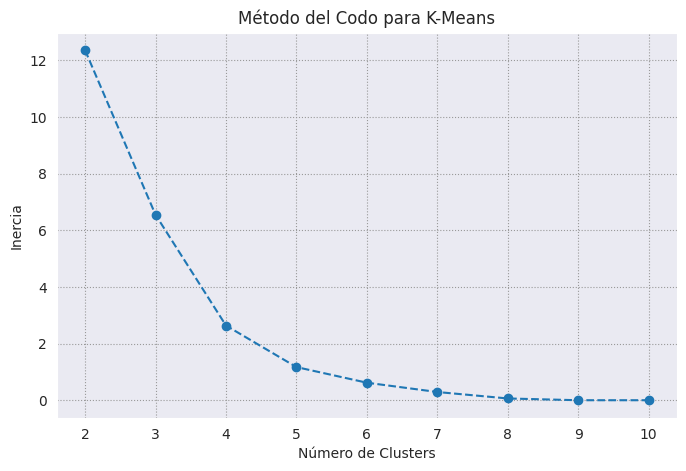

/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


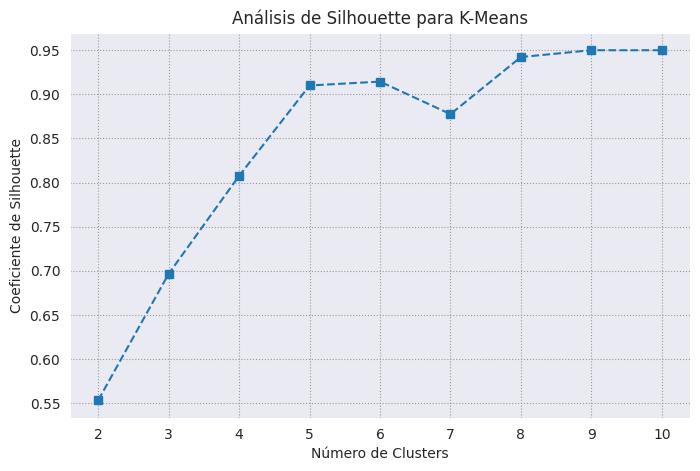

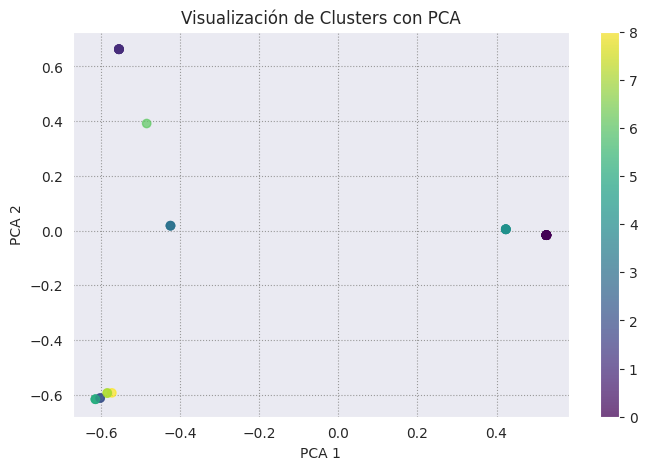

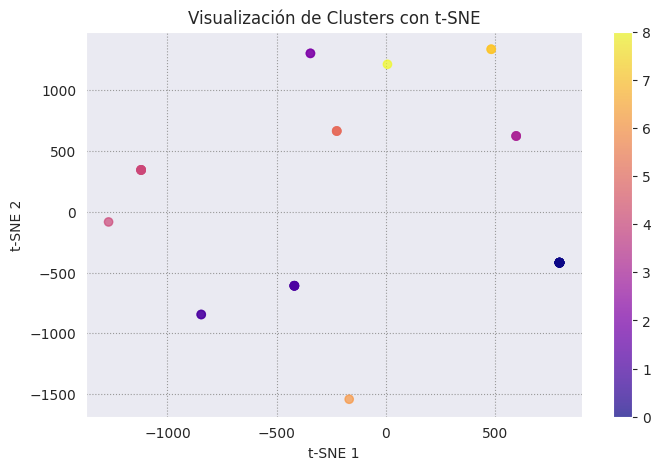

Dataset guardado exitosamente como malware_dataset.csv


In [111]:
os.makedirs(unpacked_path, exist_ok=True)

def get_md5(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def extract_imported_functions(pe):
    functions = set()
    if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            for imp in entry.imports:
                if imp.name:
                    functions.add(imp.name.decode(errors='ignore'))
    return " ".join(functions)

def calculate_entropy(data):
    if not data:
        return 0
    freq = {b: data.count(b) for b in set(data)}
    data_len = len(data)
    entropy = -sum((f / data_len) * math.log2(f / data_len) for f in freq.values())
    return entropy

def check_packed(pe):
    high_entropy_sections = sum(1 for section in pe.sections if calculate_entropy(section.get_data()) > 7.5)
    import_count = sum(len(entry.imports) for entry in getattr(pe, 'DIRECTORY_ENTRY_IMPORT', []))
    return high_entropy_sections > 0 or import_count == 0

def try_unpack(file_path):
    unpacked_file_path = os.path.join(unpacked_path, os.path.basename(file_path))
    
    try:
        result = subprocess.run(["upx", "-d", file_path, "-o", unpacked_file_path],
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if "Unpacked" in result.stdout or "Unpacked" in result.stderr:
            return unpacked_file_path  # Devuelve la nueva ruta desempaquetada
    except Exception as e:
        print(f"Error desempaquetando {os.path.basename(file_path)}: {e}")

    return None  # Si falla, devuelve None

dataset = []
for root, _, files in os.walk(malware_path):
    for file in files:
        file_path = os.path.join(root, file)
        
        try:
            pe = pefile.PE(file_path)
            is_packed = check_packed(pe)

            if is_packed:
                unpacked_file_path = try_unpack(file_path)
                if unpacked_file_path:
                    file_path = unpacked_file_path  # Usa el archivo desempaquetado
                    pe = pefile.PE(file_path)  # Carga el nuevo archivo PE
                else:
                    continue  # Si no se puede desempaquetar, lo descartamos

            file_hash = get_md5(file_path)
            imported_functions = extract_imported_functions(pe)

            dataset.append({
                "Hash": file_hash,
                "Functions": imported_functions
            })
            print(f"Procesado: {file}")

        except pefile.PEFormatError:
            print(f"{file} no es un archivo PE válido")
        except Exception as e:
            print(f"Error con {file}: {e}")

if dataset:
    df = pd.DataFrame(dataset)

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df["Functions"])

    inertia = []
    for k in range(2, MAX_CLUSTERS+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, MAX_CLUSTERS+1), inertia, marker='o', linestyle='--')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo para K-Means')
    plt.show()

    silhouette_scores = []
    for k in range(2, MAX_CLUSTERS+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, MAX_CLUSTERS+1), silhouette_scores, marker='s', linestyle='--')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Coeficiente de Silhouette')
    plt.title('Análisis de Silhouette para K-Means')
    plt.show()

    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df["KMeans_Cluster"] = kmeans.fit_predict(X)
    df["Family"] = df["KMeans_Cluster"].apply(lambda x: f"Fam{x}")

    dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
    df["DBSCAN_Cluster"] = dbscan.fit_predict(X)

    pca = PCA(n_components=2)
    reduced_X = pca.fit_transform(X.toarray())

    plt.figure(figsize=(8, 5))
    plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df["KMeans_Cluster"], cmap='viridis', alpha=0.7)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('Visualización de Clusters con PCA')
    plt.colorbar()
    plt.show()


    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    tsne_X = tsne.fit_transform(X.toarray())
    plt.figure(figsize=(8, 5))
    plt.scatter(tsne_X[:, 0], tsne_X[:, 1], c=df["KMeans_Cluster"], cmap='plasma', alpha=0.7)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('Visualización de Clusters con t-SNE')
    plt.colorbar()
    plt.show()
    
    df.to_csv("malware_dataset.csv", index=False)
    print("Dataset guardado exitosamente como malware_dataset.csv")
else:
    print("No se encontraron archivos PE válidos.")


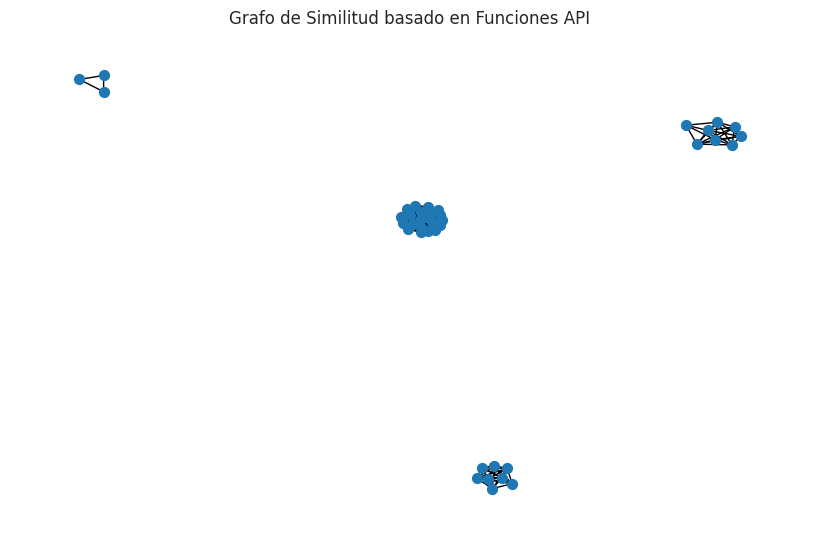

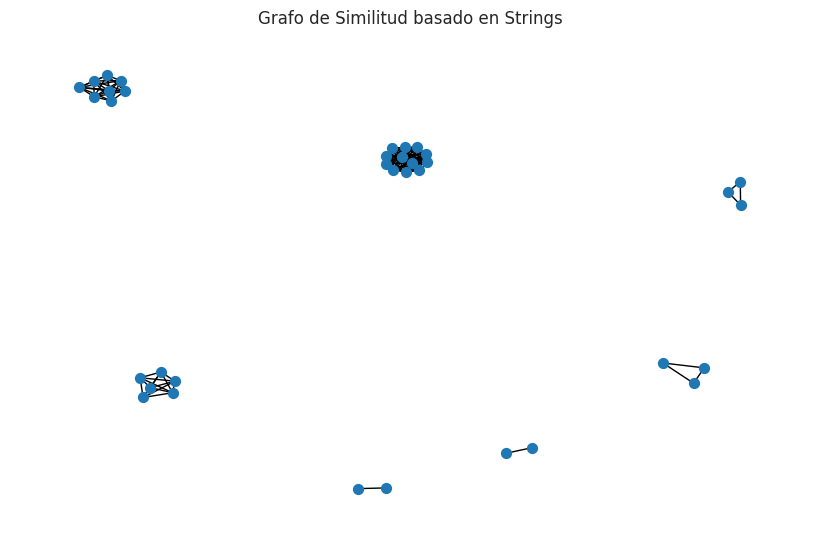

Dataset guardado exitosamente como malware_dataset.csv


In [108]:
# Grafo de similitud para funciones API
G_functions = nx.Graph()
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if functions_jaccard[i, j] > 0.5:
            G_functions.add_edge(df.loc[i, "Hash"], df.loc[j, "Hash"], weight=functions_jaccard[i, j])

plt.figure(figsize=(8, 5))
nx.draw(G_functions, with_labels=False, node_size=50)
plt.title("Grafo de Similitud basado en Funciones API")
plt.show()

# Grafo de similitud para strings
G_strings = nx.Graph()
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if strings_jaccard[i, j] > 0.5:
            G_strings.add_edge(df.loc[i, "Hash"], df.loc[j, "Hash"], weight=strings_jaccard[i, j])

plt.figure(figsize=(8, 5))
nx.draw(G_strings, with_labels=False, node_size=50)
plt.title("Grafo de Similitud basado en Strings")
plt.show()


.DS_Store no es un archivo PE válido
Total de archivos encontrados: 41
Total de archivos desempaquetados: 29


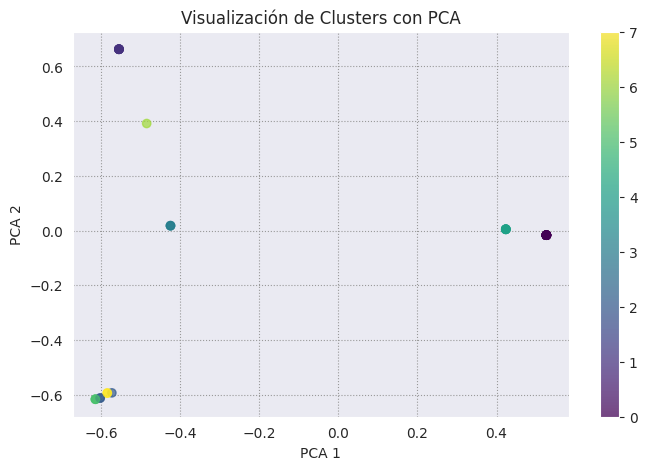

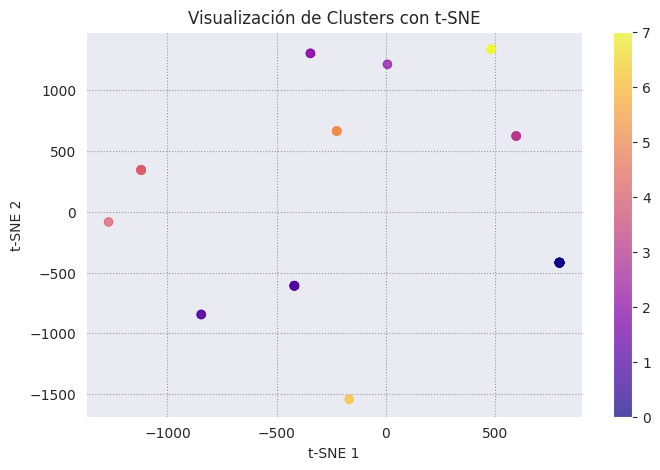

Dataset guardado exitosamente como malware_dataset.csv


In [110]:
import pefile
import os
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import subprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Constantes
malware_path = "MALWR_lab4/MALWR/"
unpacked_path = "MALWR_lab4/UNPACKED/"
MAX_CLUSTERS = 10

os.makedirs(unpacked_path, exist_ok=True)

def get_md5(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def extract_imported_functions(pe):
    functions = set()
    if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            for imp in entry.imports:
                if imp.name:
                    functions.add(imp.name.decode(errors='ignore'))
    return " ".join(functions)

def calculate_entropy(data):
    if not data:
        return 0
    freq = {b: data.count(b) for b in set(data)}
    data_len = len(data)
    entropy = -sum((f / data_len) * math.log2(f / data_len) for f in freq.values())
    return entropy

def check_packed(pe):
    high_entropy_sections = sum(1 for section in pe.sections if calculate_entropy(section.get_data()) > 7.5)
    import_count = sum(len(entry.imports) for entry in getattr(pe, 'DIRECTORY_ENTRY_IMPORT', []))
    return high_entropy_sections > 0 or import_count == 0

def try_unpack(file_path):
    unpacked_file_path = os.path.join(unpacked_path, os.path.basename(file_path))
    try:
        result = subprocess.run(["upx", "-d", file_path, "-o", unpacked_file_path],
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if "Unpacked" in result.stdout or "Unpacked" in result.stderr:
            return unpacked_file_path  # Devuelve la nueva ruta desempaquetada
    except Exception as e:
        print(f"Error desempaquetando {os.path.basename(file_path)}: {e}")
    return None  # Si falla, devuelve None

# Contadores para verificar procesamiento
total_files = 0
total_unpacked = 0
dataset = []
for root, _, files in os.walk(malware_path):
    for file in files:
        total_files += 1
        file_path = os.path.join(root, file)
        try:
            pe = pefile.PE(file_path)
            is_packed = check_packed(pe)
            if is_packed:
                unpacked_file_path = try_unpack(file_path)
                if unpacked_file_path:
                    total_unpacked += 1
                    file_path = unpacked_file_path  # Usa el archivo desempaquetado
                    pe = pefile.PE(file_path)
                else:
                    continue  # Si no se puede desempaquetar, lo descartamos
            file_hash = get_md5(file_path)
            imported_functions = extract_imported_functions(pe)
            dataset.append({"Hash": file_hash, "Functions": imported_functions})
        except pefile.PEFormatError:
            print(f"{file} no es un archivo PE válido")
        except Exception as e:
            print(f"Error con {file}: {e}")

print(f"Total de archivos encontrados: {total_files}")
print(f"Total de archivos desempaquetados: {total_unpacked}")

if dataset:
    df = pd.DataFrame(dataset)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df["Functions"])
    optimal_k = 8  # Basado en el análisis anterior
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df["KMeans_Cluster"] = kmeans.fit_predict(X)
    pca = PCA(n_components=2)
    reduced_X = pca.fit_transform(X.toarray())

    plt.figure(figsize=(8, 5))
    plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df["KMeans_Cluster"], cmap='viridis', alpha=0.7)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('Visualización de Clusters con PCA')
    plt.colorbar()
    plt.show()
    
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    tsne_X = tsne.fit_transform(X.toarray())
    plt.figure(figsize=(8, 5))
    plt.scatter(tsne_X[:, 0], tsne_X[:, 1], c=df["KMeans_Cluster"], cmap='plasma', alpha=0.7)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('Visualización de Clusters con t-SNE')
    plt.colorbar()
    plt.show()
    
    df.to_csv("malware_dataset.csv", index=False)
    print("Dataset guardado exitosamente como malware_dataset.csv")
else:
    print("No se encontraron archivos PE válidos.")


In [88]:
import os
import pefile
import pandas as pd

In [89]:
df2 = pd.read_csv("malware_dataset10.csv")

In [90]:
df2

,Hash,Functions,Packed,KMeans_Cluster,Family,DBSCAN_Cluster
0,3088654f3dd7e874d54f198225615f35,malloc LoadStringA _exit CreateThread send ine...,Yes,0,Fam0,0
1,1afc5d3ff651366800117c79f438ca58,malloc LoadStringA _exit CreateThread send ine...,Yes,0,Fam0,0
2,87d42bf400e7e4bbc9a634c99b0c3885,RegSetValueExW fwrite wcscat exit HttpQueryInf...,No,1,Fam1,1
3,cefcce265f853877c15e98e9a562e4c4,malloc LoadStringA _exit CreateThread send ine...,Yes,0,Fam0,0
4,3318200eef60f909faafbb97587248c5,malloc LoadStringA _exit CreateThread inet_add...,Yes,4,Fam4,0
5,8874b81f600b0a93723be682e939d7f2,RegSetValueExW fwrite wcscat exit HttpQueryInf...,No,1,Fam1,1
6,c738884c1337cf572e114725a112f76f,htonl inet_addr GetDeviceCaps VirtualAllocEx C...,Yes,8,Fam8,2
7,6c82816e9a59fef04f8bf0d469a21090,malloc LoadStringA _exit CreateThread send ine...,Yes,0,Fam0,0
8,cf1a8c92b688b47490580da6ba39f041,malloc LoadStringA _exit CreateThread inet_add...,Yes,4,Fam4,0
9,f95fc5593473652bbbc419331a3ffc06,malloc LoadStringA _exit CreateThread inet_add...,Yes,4,Fam4,0


In [91]:
import google.generativeai as genai


In [92]:
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [93]:
from google.api_core import retry
from tqdm.auto import tqdm
tqdm.pandas()

In [94]:
def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")
    return embedding["embedding"]

  return embed_fn

In [95]:
def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Functions'].progress_apply(make_embed_text_fn(model))
  return df

In [96]:
df_train = create_embeddings(df2)

  0%|          | 0/40 [00:00<?, ?it/s]

In [97]:
df_train

,Hash,Functions,Packed,KMeans_Cluster,Family,DBSCAN_Cluster,Embeddings
0,3088654f3dd7e874d54f198225615f35,malloc LoadStringA _exit CreateThread send ine...,Yes,0,Fam0,0,"[0.053089738, 0.0069347224, -0.038424235, -0.0..."
1,1afc5d3ff651366800117c79f438ca58,malloc LoadStringA _exit CreateThread send ine...,Yes,0,Fam0,0,"[0.053089738, 0.0069347224, -0.038424235, -0.0..."
2,87d42bf400e7e4bbc9a634c99b0c3885,RegSetValueExW fwrite wcscat exit HttpQueryInf...,No,1,Fam1,1,"[0.0063587595, 0.013778527, -0.058076736, -0.0..."
3,cefcce265f853877c15e98e9a562e4c4,malloc LoadStringA _exit CreateThread send ine...,Yes,0,Fam0,0,"[0.053089738, 0.0069347224, -0.038424235, -0.0..."
4,3318200eef60f909faafbb97587248c5,malloc LoadStringA _exit CreateThread inet_add...,Yes,4,Fam4,0,"[0.049572255, 0.004066597, -0.03423263, -0.028..."
5,8874b81f600b0a93723be682e939d7f2,RegSetValueExW fwrite wcscat exit HttpQueryInf...,No,1,Fam1,1,"[0.0063587595, 0.013778527, -0.058076736, -0.0..."
6,c738884c1337cf572e114725a112f76f,htonl inet_addr GetDeviceCaps VirtualAllocEx C...,Yes,8,Fam8,2,"[0.015828483, 0.017574716, -0.07621854, -0.030..."
7,6c82816e9a59fef04f8bf0d469a21090,malloc LoadStringA _exit CreateThread send ine...,Yes,0,Fam0,0,"[0.053089738, 0.0069347224, -0.038424235, -0.0..."
8,cf1a8c92b688b47490580da6ba39f041,malloc LoadStringA _exit CreateThread inet_add...,Yes,4,Fam4,0,"[0.049572255, 0.004066597, -0.03423263, -0.028..."
9,f95fc5593473652bbbc419331a3ffc06,malloc LoadStringA _exit CreateThread inet_add...,Yes,4,Fam4,0,"[0.049572255, 0.004066597, -0.03423263, -0.028..."


In [98]:
len(df_train['Embeddings'][0])

768

In [99]:
import numpy as np
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(40, 768)

In [100]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
tsne = TSNE(random_state=0, n_iter=1000, perplexity=5.0, )
tsne_results = tsne.fit_transform(X)

/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [102]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Family'] = df_train['Family'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Family
0,-907.447266,694.723083,Fam0
1,-472.498108,1000.376404,Fam0
2,-327.858826,295.346527,Fam1
3,342.603363,767.966736,Fam0
4,612.397034,-119.505081,Fam4
5,-327.858826,295.346527,Fam1
6,171.383102,-666.057617,Fam8
7,342.603363,767.966736,Fam0
8,762.222839,-97.076225,Fam4
9,762.222839,-97.076225,Fam4


In [103]:
print(df_train.columns)

Index(['Hash', 'Functions', 'Packed', 'KMeans_Cluster', 'Family',
       'DBSCAN_Cluster', 'Embeddings'],
      dtype='object')


(np.float64(-1090.2407501220703),
 np.float64(850.4353912353515),
 np.float64(-899.3370574951172),
 np.float64(1090.838949584961))

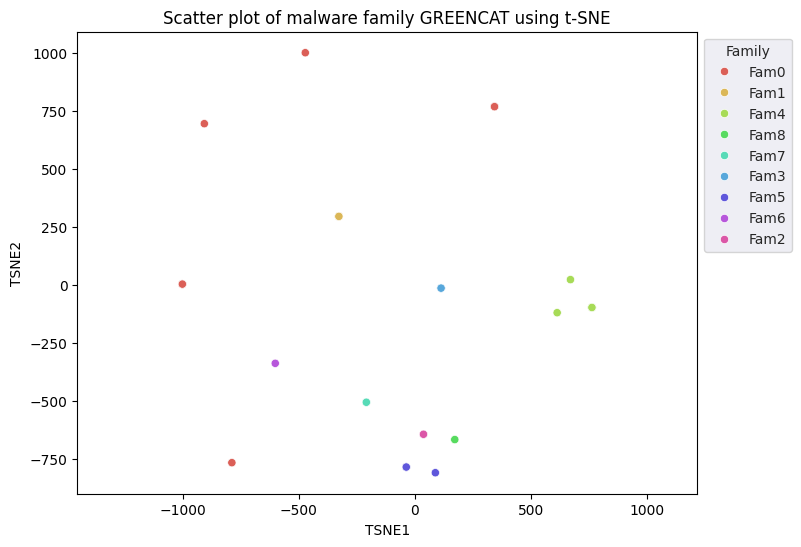

In [104]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Family', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of malware family GREENCAT using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')